# Start Notebook

In [22]:
import pandas as pd
import contractions
import re
import emoji
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
import glob
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

In [23]:
task='emotion'
import csv
import urllib.request
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]
labels

['anger', 'joy', 'optimism', 'sadness']

In [30]:
df = pd.read_pickle('data/data_22_04_2022_16_41_34/data_twitter_1.pkl')

In [31]:
df.columns = ['text', 'date']

In [32]:
df.text.values

array(['RT @POTUS: As we celebrate the progress we’ve made this Earth Day, we must also recommit ourselves to the work ahead. Let’s keep the faith and continue building a more sustainable future. https://t.co/LgtHkpPXJP',
       "This #EarthDay, I'm happy to be meeting with Philly City Council on behalf of @PennEnvironment to #GetTheLeadOut of Philly schools! \n\nOur kids shouldn't be getting poisoned by a neurotoxin in the place they go to learn &amp; grow. Let's make sure everyone has clean water to drink! https://t.co/DEf4zNXOa3",
       'RT @Khan__sir_patna: All of people wishes and happy earth day #EarthDay https://t.co/0JPxDJh0bF',
       'RT @CapsCoalition: Biden Signs Executive Order on Natural Capital, Nature-based Solutions:\n\nThe first US National Nature Assessment will enable policymakers to identify opportunities to invest in nature to achieve climate, health, social justice &amp; economic goals.\n\nhttps://t.co/XuqkTN5YcU #EarthDay https://t.co/M26OEQFVBa',
       "RT @t

# Text Cleaning

In [33]:
def remove_urls(text):
    ''' This method takes in text to remove urls and website links, if any'''
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pattern, '', text)
    return text

In [34]:
df['text_cleaned'] = df.text.apply(remove_urls)
df.text_cleaned.values

array(['RT @POTUS: As we celebrate the progress we’ve made this Earth Day, we must also recommit ourselves to the work ahead. Let’s keep the faith and continue building a more sustainable future. ',
       "This #EarthDay, I'm happy to be meeting with Philly City Council on behalf of @PennEnvironment to #GetTheLeadOut of Philly schools! \n\nOur kids shouldn't be getting poisoned by a neurotoxin in the place they go to learn &amp; grow. Let's make sure everyone has clean water to drink! ",
       'RT @Khan__sir_patna: All of people wishes and happy earth day #EarthDay ',
       'RT @CapsCoalition: Biden Signs Executive Order on Natural Capital, Nature-based Solutions:\n\nThe first US National Nature Assessment will enable policymakers to identify opportunities to invest in nature to achieve climate, health, social justice &amp; economic goals.\n\n #EarthDay ',
       "RT @tamannaahspeaks: Animals source their food from soil but our soil is dying and because of this these beautiful birds

In [35]:
def get_account_tags(text):
    ''' This method account tags'''
    tag_pattern = r'@([A-Za-z0-9_]+)'
    text = re.findall(tag_pattern, text)
    return text

In [36]:
df['account_tags'] = df.text_cleaned.apply(get_account_tags)
df[['text', 'account_tags']]

,text,account_tags
0,RT @POTUS: As we celebrate the progress we’ve ...,[POTUS]
1,"This #EarthDay, I'm happy to be meeting with P...",[PennEnvironment]
2,RT @Khan__sir_patna: All of people wishes and ...,[Khan__sir_patna]
3,RT @CapsCoalition: Biden Signs Executive Order...,[CapsCoalition]
4,RT @tamannaahspeaks: Animals source their food...,"[tamannaahspeaks, SadhguruJV, cpsavesoil]"
...,...,...
95,Celebrate Earth Day this year by taking some t...,[]
96,RT @EarthlingEco: Happy #EarthDay! \nToday is ...,[EarthlingEco]
97,RT @safespeedswpg: Happy #EarthDay! Did you kn...,"[safespeedswpg, GreenActionCtr]"
98,Free Earth Day Collection https://t.co/kiv8uesmXQ,[]


In [37]:
def get_hash_tags(text):
    ''' This method gets hashtags'''
    tag_pattern = r'#([A-Za-z0-9]+)'
    text = re.findall(tag_pattern, text)
    return text

In [38]:
df['hash_tags'] = df.text_cleaned.apply(get_hash_tags)
df[['text', 'hash_tags']]

,text,hash_tags
0,RT @POTUS: As we celebrate the progress we’ve ...,[]
1,"This #EarthDay, I'm happy to be meeting with P...","[EarthDay, GetTheLeadOut]"
2,RT @Khan__sir_patna: All of people wishes and ...,[EarthDay]
3,RT @CapsCoalition: Biden Signs Executive Order...,[EarthDay]
4,RT @tamannaahspeaks: Animals source their food...,[MyconnectwithSoil]
...,...,...
95,Celebrate Earth Day this year by taking some t...,[]
96,RT @EarthlingEco: Happy #EarthDay! \nToday is ...,"[EarthDay, EarthDay]"
97,RT @safespeedswpg: Happy #EarthDay! Did you kn...,"[EarthDay, VisionZero, ClimateActionNow, stree..."
98,Free Earth Day Collection https://t.co/kiv8uesmXQ,[]


In [39]:
def preprocess_text(text):
    # remove accounts and hash tags
    cleaned_text = re.sub(r'(@|#)([A-Za-z0-9_]+)', '', text)
    # Keep only English alphabetts, digits and spaces
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]+', '', cleaned_text)
    word_list = []
    for each_word in cleaned_text.split(' '):
        word_list.append(contractions.fix(each_word).lower())
    word_list = [
        wnl.lemmatize(each_word.strip()) for each_word in word_list
        if each_word not in STOPWORDS and each_word.strip() != ''
    ]
    return " ".join(word_list)

In [40]:
df['text_preprocessed'] = df.text_cleaned.apply(preprocess_text)
df[['text', 'text_preprocessed']]

,text,text_preprocessed
0,RT @POTUS: As we celebrate the progress we’ve ...,rt celebrate progress we have made earth day m...
1,"This #EarthDay, I'm happy to be meeting with P...",i am happy meeting philly city council behalf ...
2,RT @Khan__sir_patna: All of people wishes and ...,rt people wish happy earth day
3,RT @CapsCoalition: Biden Signs Executive Order...,rt biden sign executive order natural capital ...
4,RT @tamannaahspeaks: Animals source their food...,rt animal source food soil soil dying beautifu...
...,...,...
95,Celebrate Earth Day this year by taking some t...,celebrate earth day year taking time learn imp...
96,RT @EarthlingEco: Happy #EarthDay! \nToday is ...,rt happy today reminder goal limit global warm...
97,RT @safespeedswpg: Happy #EarthDay! Did you kn...,rt happy know lowering speed residential road ...
98,Free Earth Day Collection https://t.co/kiv8uesmXQ,free earth day collection


# Emojis

In [41]:
sample = "general)\n\n🌎🌲🍁"

In [42]:
emoji.emoji_lis(sample) # Did not use distinct_emoji_lis because I wanted all counts

[{'location': 10, 'emoji': '🌎'},
 {'location': 11, 'emoji': '🌲'},
 {'location': 12, 'emoji': '🍁'}]

In [43]:
def get_emoji_list(text):
    dict_loc_emoji = emoji.emoji_lis(text)
    if dict_loc_emoji:
        list_emojis = [each['emoji'] for each in dict_loc_emoji]
        return list_emojis
    return None

In [44]:
df['emoji_lists'] = df.text_cleaned.apply(get_emoji_list)
df[['text', 'emoji_lists']]

,text,emoji_lists
0,RT @POTUS: As we celebrate the progress we’ve ...,None
1,"This #EarthDay, I'm happy to be meeting with P...",None
2,RT @Khan__sir_patna: All of people wishes and ...,None
3,RT @CapsCoalition: Biden Signs Executive Order...,None
4,RT @tamannaahspeaks: Animals source their food...,None
...,...,...
95,Celebrate Earth Day this year by taking some t...,[🌏]
96,RT @EarthlingEco: Happy #EarthDay! \nToday is ...,"[🌎, 🌍, 🌏, 🌳]"
97,RT @safespeedswpg: Happy #EarthDay! Did you kn...,None
98,Free Earth Day Collection https://t.co/kiv8uesmXQ,None


# Sentiment Analysis

In [47]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis")

In [48]:
df['sentiment'] = df.text.apply(lambda x: classifier(x)[0]['label'])

In [49]:
df.head()

,text,date,text_cleaned,account_tags,hash_tags,text_preprocessed,emoji_lists,sentiment
0,RT @POTUS: As we celebrate the progress we’ve ...,Fri Apr 22 15:41:33 +0000 2022,RT @POTUS: As we celebrate the progress we’ve ...,[POTUS],[],rt celebrate progress we have made earth day m...,None,POSITIVE
1,"This #EarthDay, I'm happy to be meeting with P...",Fri Apr 22 15:41:33 +0000 2022,"This #EarthDay, I'm happy to be meeting with P...",[PennEnvironment],"[EarthDay, GetTheLeadOut]",i am happy meeting philly city council behalf ...,None,POSITIVE
2,RT @Khan__sir_patna: All of people wishes and ...,Fri Apr 22 15:41:33 +0000 2022,RT @Khan__sir_patna: All of people wishes and ...,[Khan__sir_patna],[EarthDay],rt people wish happy earth day,None,POSITIVE
3,RT @CapsCoalition: Biden Signs Executive Order...,Fri Apr 22 15:41:33 +0000 2022,RT @CapsCoalition: Biden Signs Executive Order...,[CapsCoalition],[EarthDay],rt biden sign executive order natural capital ...,None,POSITIVE
4,RT @tamannaahspeaks: Animals source their food...,Fri Apr 22 15:41:33 +0000 2022,RT @tamannaahspeaks: Animals source their food...,"[tamannaahspeaks, SadhguruJV, cpsavesoil]",[MyconnectwithSoil],rt animal source food soil soil dying beautifu...,None,POSITIVE


# Emotion Analysis

In [52]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

MODEL = f"cardiffnlp/twitter-roberta-base-emotion"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [76]:
def get_emotion(text):
    labels = ['anger', 'joy', 'optimism', 'sadness'] 
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = softmax(output[0][0].detach().numpy())
    ranking = np.argmax(scores)
    return labels[ranking]

In [77]:
df['emotion'] = df.text.apply(get_emotion)

In [78]:
text = df.text[10]
get_emotion(text)

'optimism'

In [79]:
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.graph_objs import *

fig = px.histogram(df,
                   x="sentiment",
                   template='plotly_white',
                   color='sentiment'
                  )
fig.update_layout(
    title={
        'text': "Sentiment",
        'x' : 0.5,
        'xanchor': 'center'
    })
fig.update_yaxes(title='Count').update_xaxes(title='Sentiment')
fig.show()

# Wordcloud

In [ ]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = ' '.join(list(df.text_preprocessed))
print(text)
# read the mask / color image taken from
# http://jirkavinse.deviantart.com/art/quot-Real-Life-quot-Alice-282261010
alice_coloring = np.array(Image.open(path.join(d, "earth_image.jpg")))
stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white", max_words=2000, mask=alice_coloring,
               stopwords=stopwords, max_font_size=40, random_state=42)
# generate word cloud
wc.generate(text)

# create coloring from image
image_colors = ImageColorGenerator(alice_coloring)

plt.axis("off")
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.show()

In [133]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

text = ' '.join(list(df.text_preprocessed))

earth_image = plt.imread("abstract-world-map-celestial-images.jpg")
earth_coloring = np.array(Image.open(path.join(d, "abstract-world-map-celestial-images.jpg")))
stopwords = set(STOPWORDS)
stopwords.add("rt")

In [134]:
wc = WordCloud(background_color="rgba(255, 255, 255, 0)", 
               mode="RGBA",
               max_words=500,
               stopwords=stopwords,
               mask=earth_coloring,
               collocations=True,
               collocation_threshold=15,
               repeat=False,
               colormap='GnBu',
               include_numbers=True,
               font_path='font/LibreBaskerville-Regular.ttf',
               random_state=42)
# generate word cloud
wc.generate(text)

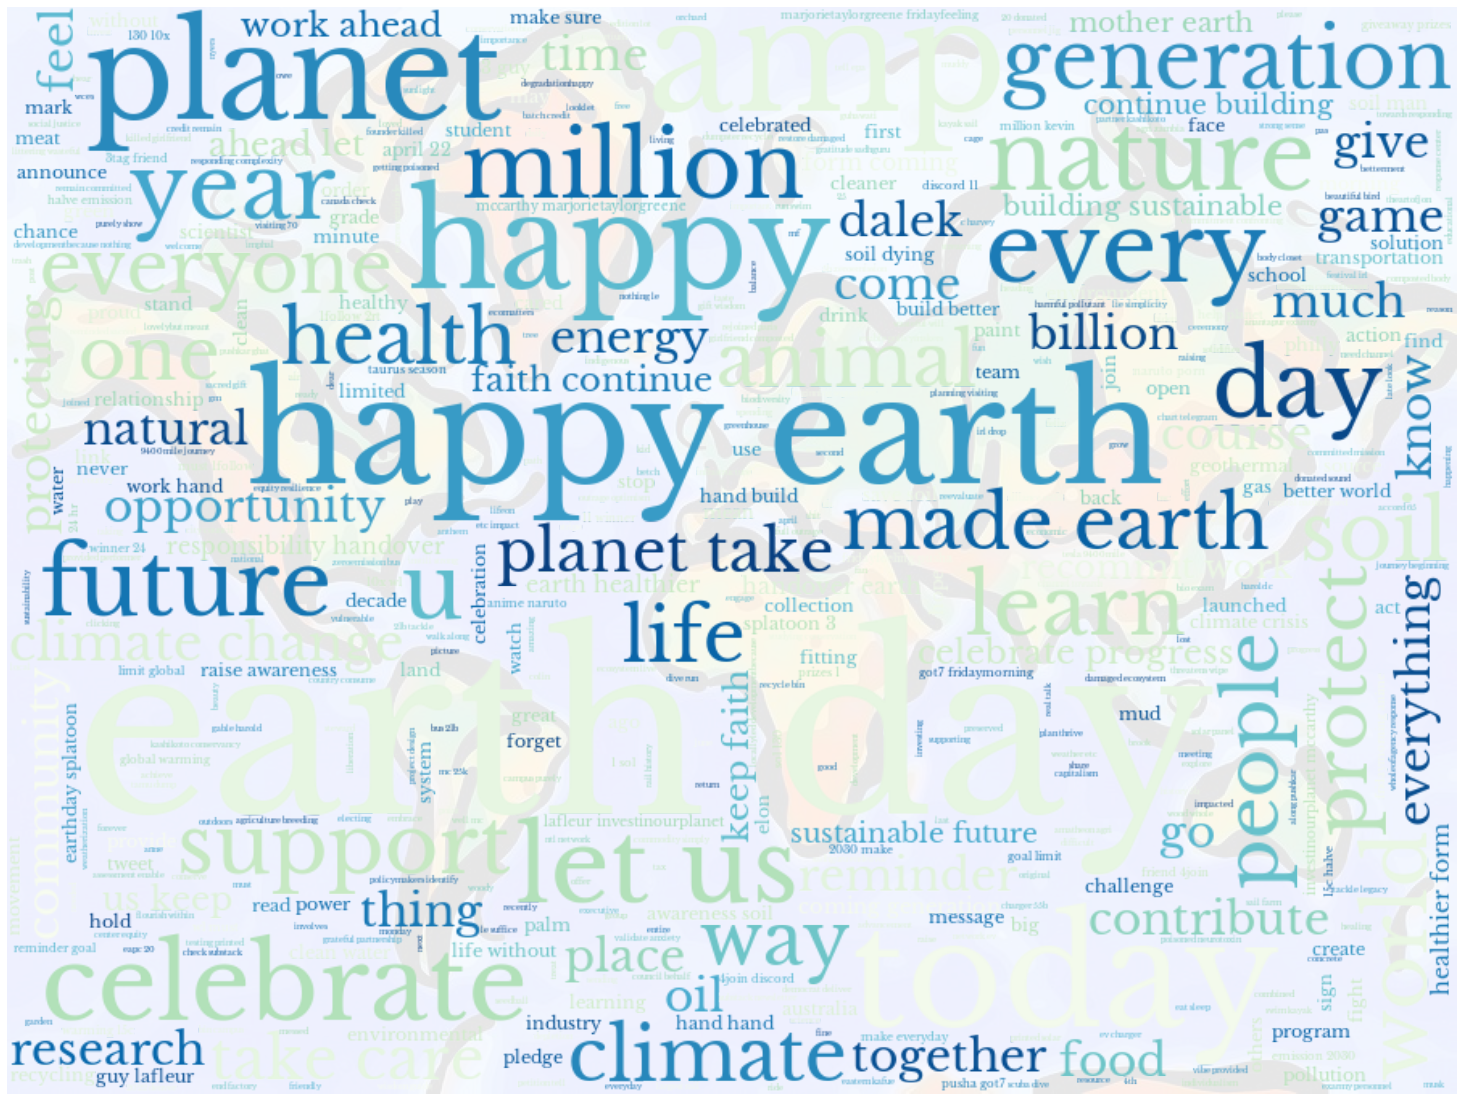

In [135]:
# create coloring from image
# image_colors = ImageColorGenerator(earth_coloring)
plt.figure(figsize=(50, 20), facecolor=None)
plt.axis("off")
plt.imshow(earth_image, alpha=0.1)
# plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.imshow(wc, interpolation="bilinear")
plt.show()

# Keyword Analysis

In [58]:
df['has_climate_change'] = df.text.str.lower().str.contains('climate change')

In [59]:
df.has_climate_change.value_counts()

False    96
True      4
Name: has_climate_change, dtype: int64

In [60]:
term = 'and'

In [61]:
df['has_term'] = df.text.str.lower().str.contains(term)
df.has_term.value_counts()

True     53
False    47
Name: has_term, dtype: int64

In [62]:
x = dict(df.has_term.value_counts())
for k, v in x.items():
    if k:
        print('Contains <b>{}</b>'.format(term))
    else:
        print('Does not contain <b>{}</b>'.format(term))

Contains <b>and</b>
Does not contain <b>and</b>


In [65]:
import plotly.graph_objects as go

labels = ['Contains {}', 'Does not contain {}'] #REFINE THIS
values = list(df.has_term.value_counts())

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(
    title={
        'text': "Keyword Analysis",
        'x' : 0.5,
        'xanchor': 'center'
    })
fig.show()

In [66]:
def process_term(df, term):
    df['has_term'] = df.text.str.lower().str.contains(term)
    dict_has_term = dict(df.has_term.value_counts())
    return dict_has_term

def gen_label(dict_val_counts, term):
    new_dict_val_counts = {}
    for key, value in dict_val_counts.items():
        if key:
            new_label = "Contains \"{}\"".format(term)
            new_dict_val_counts[new_label] = value
        else:
            new_label = "Does not Contain \"{}\"".format(term)
            new_dict_val_counts[new_label] = value
    return new_dict_val_counts

In [67]:
test_dict = process_term(df, 'soil')
print(test_dict)
dict_data_for_pie = gen_label(test_dict, 'soil')

{False: 89, True: 11}


In [68]:
fig = go.Figure(data=[go.Pie(labels=list(dict_data_for_pie.keys()), values=list(dict_data_for_pie.values()), hole=.3)])
fig.show()

# Hashtags

In [69]:
flat_list = []
for each_list in list(df.hash_tags):
    if each_list:
        for each_tag in each_list:
            flat_list.append(each_tag.lower()) 
flat_list

['earthday',
 'gettheleadout',
 'earthday',
 'earthday',
 'myconnectwithsoil',
 'takecarewithsnoopy',
 'takecareoftheearth',
 'earthday',
 'unlitter',
 'cleanertrucks',
 'earthday',
 'takecarewithsnoopy',
 'takecareoftheearth',
 'earthday',
 'arctic',
 'earthday',
 'earth',
 'carbonremoval',
 'earthday',
 'myconnectwithsoil',
 'savesoil',
 'earthday',
 'myconnectwithsoil',
 'internationalmotherearthday',
 'motherearthday',
 'earthday',
 'biodiversityday',
 'connect2earth',
 'earthdaytobiodiversityday',
 'biodiversityday',
 'earthday',
 'earthday',
 'savesoil',
 'myconnectwithsoil',
 'earthday',
 'takecarewithsnoopy',
 'takecareoftheearth',
 'earthday',
 'earthday',
 'protectourplanet',
 'earthday',
 'savesoil',
 'myconnectwithsoil',
 'earthday',
 'ai',
 'health',
 'startup',
 'lifecoach',
 'tweet100',
 'earthday',
 'ai',
 'health',
 'startup',
 'lifecoach',
 'tweet100',
 'earthday',
 'ai',
 'health',
 'startup',
 'lifecoach',
 'tweet100',
 'ad',
 'solana',
 'nftgiveaway',
 'earthday',


In [70]:
from collections import Counter

dict_counter = dict(Counter(flat_list))
hashtag_count = pd.DataFrame.from_dict(dict_counter, orient='index')

In [71]:
hashtag_count.reset_index(inplace=True)
hashtag_count.columns = ['hashtag', 'count']

In [72]:
hashtag_count

,hashtag,count
0,earthday,50
1,gettheleadout,1
2,myconnectwithsoil,11
3,takecarewithsnoopy,3
4,takecareoftheearth,3
...,...,...
67,visionzero,1
68,streetsforlife,1
69,climatecrisis,1
70,motherearth,1
